# Kezdjünk egy egyszerű döntési fával

## Készítsünk osztályozási fákat

A könyvtárak változása miatt FutureWarning, vagyis Jövőre vonatkozó figyelmeztetések jelennek meg a Jupyter Notebookban. A https://blog.johnmuellerbooks.com/2023/05/08/warning-messages-in-jupyter-notebook-example-code/ címen elérhető blogbejegyzésben olvashatsz annak részleteiről, hogy ezt mi okozza, és mit tehetsz ennek a megoldására. Az alábbi kóddal elkerülheted ezeket a figyelmeztetéseket ebben a konkrét kódrészben.

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
from sklearn.datasets import fetch_openml
import pandas as pd

def gombaadatok_betöltése():
    jellemzők, cél = fetch_openml(
        data_id=24, return_X_y=True, as_frame=True)
    X = pd.get_dummies(jellemzők)
    y = (cél == "p").astype(int)
    return X, y


In [3]:
X, y = gombaadatok_betöltése()

see: https://www.openml.org/search?type=data&status=active&id=24

In [4]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
keresztvalidáció = KFold(n_splits=5,
                        shuffle=True,
                        random_state=0)

In [5]:
import numpy as np
from sklearn import tree
for mélység in range(1,10):
    fa_osztályozó = tree.DecisionTreeClassifier(
        max_depth=mélység, random_state=0)
    if fa_osztályozó.fit(X,y).tree_.max_depth < mélység:
        break
    pontszám = np.mean(cross_val_score(fa_osztályozó,
                                    X, y,
                                    scoring='accuracy',
                                    cv=keresztvalidáció))
    print('Mélység: %i Pontosság: %.3f' % (mélység,pontszám))

Mélység: 1 Pontosság: 0.887
Mélység: 2 Pontosság: 0.954
Mélység: 3 Pontosság: 0.984
Mélység: 4 Pontosság: 0.991
Mélység: 5 Pontosság: 0.999
Mélység: 6 Pontosság: 0.999
Mélység: 7 Pontosság: 1.000


In [6]:
fa_osztályozó = tree.DecisionTreeClassifier(
    max_depth=5,
    random_state=0)
fa_osztályozó.fit(X.values, y)
pontszám = np.mean(cross_val_score(fa_osztályozó, X, y, 
                                scoring='accuracy', 
                                cv=keresztvalidáció))
print('Pontosság: %.3f' % pontszám)

Pontosság: 0.999


# A DTREEVIZ TELEPÍTÉSE
Ahhoz, hogy tovább tudj haladni a letölthető forráskódban, telepítened kell a dtreeviz csomagot a https://github.com/parrt/dtreeviz címen található, a konkrét platformodhoz megadott utasítások alapján. Ezekben az utasításokban kissé elavult verziószámok szerepelnek. A könyvben szereplő kódot a 8.0.5-ös verzióval teszteltük. Ügyelj arra, hogy az adott platformra vonatkozó utasításokat használd. Mindenképpen végezd el a dot.exe tesztjét, mivel erre a konkrét eszközre lesz szükséged ahhoz, hogy megjelenítsd az elemeket a képernyőn. Ha már futtatod a letölthető forrást, mentsd el, és lépj ki mind a letölthető forrásból, mind a Jupyter Notebookból, hogy a módosítások érvénybe lépjenek. A telepítés végrehajtásával nem teljesíted a Python követelményeit teljes mértékben; ezután még futtatnod kell a letölthető forrásban szereplő !pip install detreeviz sort is.

In [7]:
!pip install dtreeviz

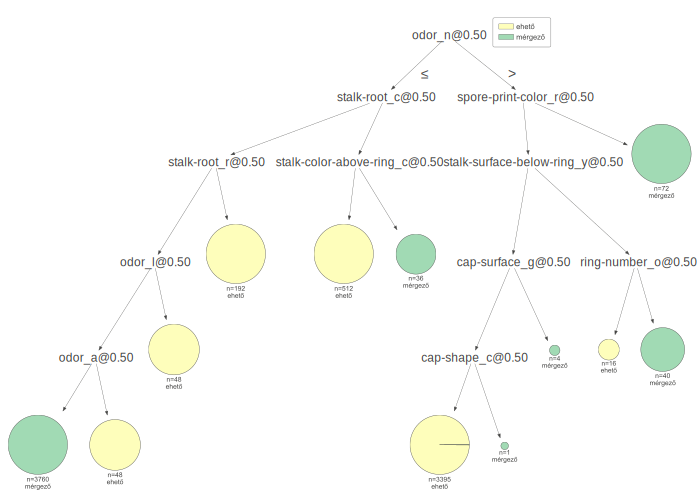

In [8]:
import logging
import dtreeviz

logging.getLogger('matplotlib.font_manager').disabled = True
viz = dtreeviz.model(fa_osztályozó, X, y, 
                    feature_names=X.columns, 
                    class_names=['ehető', 'mérgező'])

viz.view(fancy=False)

## Készítsünk regressziós fákat

In [9]:
from sklearn.datasets import fetch_california_housing
import pandas as pd

def kaliforniai_lakásadatok_betöltése():
    adathalmaz = fetch_california_housing()
    X = pd.DataFrame(data=adathalmaz.data,
                     columns=adathalmaz.feature_names)
    y = pd.Series(data=adathalmaz.target, name="cél")
    return X, y

In [10]:
from sklearn.tree import DecisionTreeRegressor

X, y = kaliforniai_lakásadatok_betöltése()
regressziós_fa = tree.DecisionTreeRegressor(
    min_samples_split=30, min_samples_leaf=10,
    random_state=0)
regressziós_fa.fit(X,y)
pontszám = np.mean(cross_val_score(regressziós_fa,
                   X, y,
                   scoring='neg_mean_squared_error',
                   cv=keresztvalidáció))
print('Átlagos négyzetes hiba: %.3f' % abs(pontszám))

Átlagos négyzetes hiba: 0.367


# Vesszünk el egy véletlen erdőben

## Tegyük elérhetővé a gépi tanulást

In [11]:
import numpy as np
import pandas as pd

def német_hitelképességi_adatok_betöltése():
    url = "https://archive.ics.uci.edu/ml/"
    url += "machine-learning-databases"
    url += "/statlog/german/german.data-numeric"
    col_names = [
        "checking_account", "duration", "credit_history",
        "credit_amount", "savings_account",
        "employment_duration", "personal_status",
        "residence_duration", "property", "age",
        "other_installment_plans", "number_credits",
        "people_liable", "telephone", "foreign_worker",
        "purpose_car_new", "purpose_car_used",
        "other_debtors_none",
        "other_debtors_coapplicant",
        "housing_rent", "housing_own",
        "job_unskilled_non_resident",
        "job_unskilled_resident", "job_employee",
        "credit_risk"]
    ak = pd.read_csv(
        url, header=None, names=col_names,
        delim_whitespace=True)
    X = ak.iloc[:, :-1]
    y = (ak.iloc[:, -1] == 2).astype(int) # 2 = "Rossz"
    return X, y

X, y = német_hitelképességi_adatok_betöltése()

In [12]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

fa_osztályozó = DecisionTreeClassifier(random_state=0)
keresztvalidáció = KFold(
    n_splits=5, shuffle=True, random_state=0)
zsákolás = BaggingClassifier(fa_osztályozó,
                            max_samples=0.7,
                            max_features=0.7,
                            n_estimators=300,
                            random_state=0)

pontszámok = np.mean(cross_val_score(zsákolás, X, y,
                                 scoring='roc_auc',
                                 cv=keresztvalidáció))
print(f'ROC-AUC: {pontszámok:.3f}')

ROC-AUC: 0.795


## Használjunk véletlen erdő osztályozót

In [13]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

keresztvalidáció = KFold(
    n_splits=5, shuffle=True, random_state=0)
véletlen_erdő = RandomForestClassifier(n_estimators=300,
                                       random_state=0)
pontszám = np.mean(cross_val_score(véletlen_erdő, X, y,
                                scoring='roc_auc',
                                cv=keresztvalidáció))
print(f'ROC-AUC: {pontszámok:.3f}')

ROC-AUC: 0.795


In [14]:
from sklearn.model_selection import validation_curve

param_tartomány = [50, 150, 300, 600, 900, 1200, 1800,
               2400, 3000, 3600]
keresztvalidáció = KFold(
    n_splits=5, shuffle=True, random_state=0)
véletlen_erdő = RandomForestClassifier(
    n_estimators=300, n_jobs=-1, random_state=0)
tanító_pontszámok, teszt_pontszámok = validation_curve(
    véletlen_erdő, X, y, param_name='n_estimators',
    param_range=param_tartomány, cv=keresztvalidáció,
    scoring='roc_auc')
átlagos_teszt_pontszámok = np.mean(teszt_pontszámok, axis=1)
for i, pontszám in enumerate(átlagos_teszt_pontszámok):
    print(f"n_estimators (becslők száma): {param_tartomány[i]:4}, " +
          f"ROC-AUC pontszám: {pontszám:.3f}")

n_estimators (becslők száma):   50, ROC-AUC pontszám: 0.779
n_estimators (becslők száma):  150, ROC-AUC pontszám: 0.793
n_estimators (becslők száma):  300, ROC-AUC pontszám: 0.797
n_estimators (becslők száma):  600, ROC-AUC pontszám: 0.799
n_estimators (becslők száma):  900, ROC-AUC pontszám: 0.800
n_estimators (becslők száma): 1200, ROC-AUC pontszám: 0.800
n_estimators (becslők száma): 1800, ROC-AUC pontszám: 0.800
n_estimators (becslők száma): 2400, ROC-AUC pontszám: 0.801
n_estimators (becslők száma): 3000, ROC-AUC pontszám: 0.800
n_estimators (becslők száma): 3600, ROC-AUC pontszám: 0.800


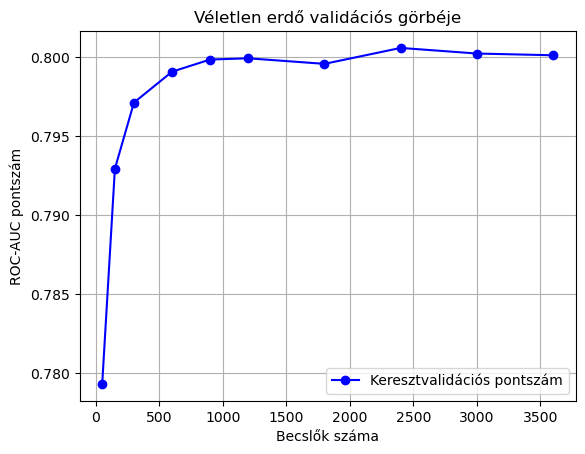

In [15]:
import matplotlib.pyplot as dg

dg.plot(param_tartomány, átlagos_teszt_pontszámok,
         'bo-', label='Keresztvalidációs pontszám')
dg.xlabel('Becslők száma')
dg.ylabel('ROC-AUC pontszám')
dg.title('Véletlen erdő validációs görbéje')
dg.legend(loc='lower right')
dg.grid(True)
dg.show()

## Használjunk véletlen erdő regresszort

In [16]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, KFold

X, y = kaliforniai_lakásadatok_betöltése()

ve_regresszor = RandomForestRegressor(
    n_estimators=300, random_state=0)
ke = KFold(n_splits=5, shuffle=True, random_state=0)

pontszámok = cross_val_score(
    ve_regresszor, X, y, scoring='neg_mean_squared_error',
    cv=ke)
ánh_átlag = abs(pontszámok.mean())

print(f"Átlagos négyzetes hiba: {ánh_átlag:.3f}")

Átlagos négyzetes hiba: 0.252


## Optimalizáljunk egy véletlen erdőt

In [17]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold

X, y = német_hitelképességi_adatok_betöltése()
keresztvalidáció = KFold(
    n_splits=5, shuffle=True, random_state=0)
oszt = RandomForestClassifier(random_state=0)
pontozó = "roc_auc"

In [18]:
from sklearn.model_selection import GridSearchCV

max_jellemzők = [X.shape[1] // 3, "sqrt", "log2", None]
min_levél_mintaszám = [1, 10, 30]
becslők_száma = [50, 100, 300, 500, 1000]
keresési_rács = {
    "n_estimators": becslők_száma,
    "max_features": max_jellemzők,
    "min_samples_leaf": min_levél_mintaszám}
keresési_ke = GridSearchCV(
    estimator=oszt,
    param_grid=keresési_rács,
    scoring=pontozó,
    cv=keresztvalidáció)
keresési_ke.fit(X, y)

GridSearchCV(cv=KFold(n_splits=5, random_state=0, shuffle=True),
             estimator=RandomForestClassifier(random_state=0),
             param_grid={'max_features': [8, 'sqrt', 'log2', None],
                         'min_samples_leaf': [1, 10, 30],
                         'n_estimators': [50, 100, 300, 500, 1000]},
             scoring='roc_auc')

In [19]:
legjobb_param = keresési_ke.best_params_
legjobb_pontszám = keresési_ke.best_score_
print(f"Legjobb paraméterek: {legjobb_param}")
print(f"Legjobb pontszám: {legjobb_pontszám}")

Legjobb paraméterek: {'max_features': 8, 'min_samples_leaf': 1, 'n_estimators': 1000}
Legjobb pontszám: 0.8008907775588991


# Gyorsítsunk az előrejelzéseken

In [20]:
X, y = német_hitelképességi_adatok_betöltése()

## Legyünk tisztában azzal, hogy a sok gyenge előrejelző nyer

In [21]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import roc_auc_score

ada = AdaBoostClassifier(
   n_estimators=1000, learning_rate=0.01, random_state=0)
ke = KFold(n_splits=5, shuffle=True, random_state=0)
roc_pontszámok = cross_val_score(
    ada, X, y, scoring='roc_auc', cv=ke)
átlag_pontszám = roc_pontszámok.mean()
print(f'ROC-AUC pontszám: {átlag_pontszám:.3f}')

ROC-AUC pontszám: 0.774


## Állítsunk be egy gradiens boosting osztályozót

In [22]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

X, y = német_hitelképességi_adatok_betöltése()

keresztvalidáció = KFold(
    n_splits=5, shuffle=True, random_state=0)

gno = GradientBoostingClassifier(
    n_estimators=300, subsample=1.0, max_depth=2,
    learning_rate=0.1, random_state=0)
keresztvalidáció = KFold(
    n_splits=5, shuffle=True, random_state=0)
pontszám = np.mean(cross_val_score(
    gno, X, y, scoring='roc_auc', cv=keresztvalidáció))
print(f'ROC-AUC: {pontszám:.3f}')

ROC-AUC: 0.784


## Futtassunk egy gradiens boosting regresszort

In [23]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score, KFold

X, y = kaliforniai_lakásadatok_betöltése()

gnr = GradientBoostingRegressor(
    n_estimators=1000, subsample=1.0, max_depth=3,
    learning_rate=0.01, random_state=0)

ke = KFold(n_splits=5, shuffle=True, random_state=0)

ánh = np.mean(cross_val_score(
    gnr, X, y, scoring='neg_mean_squared_error', cv=ke))

print(f"Átlagos négyzetes hiba: {abs(ánh):.3f}")

Átlagos négyzetes hiba: 0.285


## Használjuk a GBM hiperparamétereit

In [24]:
from sklearn.model_selection import KFold

X, y = kaliforniai_lakásadatok_betöltése()

keresztell = KFold(
    n_splits=5, shuffle=True, random_state=0)

gnr = GradientBoostingRegressor(
    n_estimators=1000,  subsample=1.0, 
    max_depth=3,  learning_rate=0.01, 
    random_state=0)

In [25]:
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

X, y = kaliforniai_lakásadatok_betöltése()
keresztellenőrzés = KFold(
    n_splits=5, shuffle=True, random_state=0)
gnr = GradientBoostingRegressor(
    n_estimators=1000, learning_rate=0.01,
    random_state=0)
keresési_rács = {'subsample': [1.0, 0.9, 0.7],
               'max_depth': [2, 3, 4, 5, 6]}
keresési_függv = GridSearchCV(
    estimator=gnr, param_grid=keresési_rács,
    scoring='neg_mean_squared_error',
    cv=keresztellenőrzés)
keresési_függv.fit(X, y)
legjobb_param = keresési_függv.best_params_
legjobb_pontszám = abs(keresési_függv.best_score_)
print(f'A legjobb paraméterek: {legjobb_param}')
print(f'A legjobb átlagos négyzetes hiba: {legjobb_pontszám:.3f}')

A legjobb paraméterek: {'max_depth': 6, 'subsample': 0.7}
A legjobb átlagos négyzetes hiba: 0.220


## Használjuk az XGBoost algoritmust

In [26]:
import xgboost as xgb
from sklearn.model_selection import cross_val_score, KFold

X, y = német_hitelképességi_adatok_betöltése()

ke = KFold(n_splits=5, shuffle=True, random_state=0)

param = {'n_estimators': 800, 'subsample': 0.7,
          'max_depth': 2, 'learning_rate': 0.015,
          'random_state': 0,
          'objective': 'binary:logistic',
          'eval_metric': 'auc'}

gno = xgb.XGBClassifier(**param)

pontszám = np.mean(cross_val_score(
    gno, X, y, scoring='roc_auc', cv=ke))

print(f'ROC-AUC: {pontszám:.3f}')

ROC-AUC: 0.801


In [27]:
import xgboost as xgb
from sklearn.model_selection import cross_val_score, KFold

X, y = kaliforniai_lakásadatok_betöltése()

xg_reg = xgb.XGBRegressor(
    n_estimators=900, subsample=0.8, max_depth=5,
    learning_rate=0.07, random_state=0)

ke = KFold(n_splits=5, shuffle=True, random_state=0)

ánh = np.mean(cross_val_score(
    xg_reg, X, y, scoring='neg_mean_squared_error',
    cv=ke))

print(f"Átlagos négyzetes hiba: {abs(ánh):.3f}")

Átlagos négyzetes hiba: 0.197
